In [1]:
import torch
import math
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Image
import torch.nn.functional as F  # Parameterless functions, like (some) activation functions
import torchvision.datasets as datasets  # Standard datasets
import torchvision.transforms as transforms  # Transformations we can perform on our dataset for augmentation
from torch import optim  # For optimizers like SGD, Adam, etc.
from torch import nn  # All neural network modules
from torch.utils.data import (
    DataLoader,
)  # Gives easier dataset management by creating mini batches etc.
from tqdm import tqdm  # For nice progress bar!
%matplotlib inline

Device used to run is: cuda

Data Loading:
-------------



  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting dataset/MNIST\raw\train-images-idx3-ubyte.gz to dataset/MNIST\raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting dataset/MNIST\raw\train-labels-idx1-ubyte.gz to dataset/MNIST\raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting dataset/MNIST\raw\t10k-images-idx3-ubyte.gz to dataset/MNIST\raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting dataset/MNIST\raw\t10k-labels-idx1-ubyte.gz to dataset/MNIST\raw



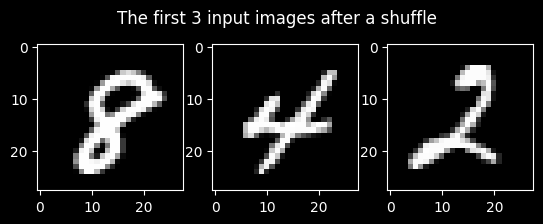

The first 3 targets are: [8, 4, 2]

Training:
---------

Epoch #0:


100%|██████████| 938/938 [00:18<00:00, 49.85it/s] 


current loss: 0.42330404174035546

Epoch #1:


100%|██████████| 938/938 [00:15<00:00, 61.52it/s] 


current loss: 0.21868177319068643

Epoch #2:


100%|██████████| 938/938 [00:14<00:00, 62.82it/s] 


current loss: 0.16811581910736778

Epoch #3:


100%|██████████| 938/938 [00:20<00:00, 45.09it/s]


current loss: 0.13618358987560278

Epoch #4:


100%|██████████| 938/938 [00:19<00:00, 47.90it/s]


current loss: 0.11447537616729292

Epoch #5:


100%|██████████| 938/938 [00:16<00:00, 58.16it/s]


current loss: 0.09861744115494493

Epoch #6:


100%|██████████| 938/938 [00:10<00:00, 85.94it/s] 


current loss: 0.08594617507219918

Epoch #7:


100%|██████████| 938/938 [00:18<00:00, 50.64it/s]


current loss: 0.07700010205803713

Epoch #8:


100%|██████████| 938/938 [00:11<00:00, 79.19it/s] 


current loss: 0.06827585135888396

Epoch #9:


100%|██████████| 938/938 [00:14<00:00, 63.44it/s] 


current loss: 0.062176264842340685


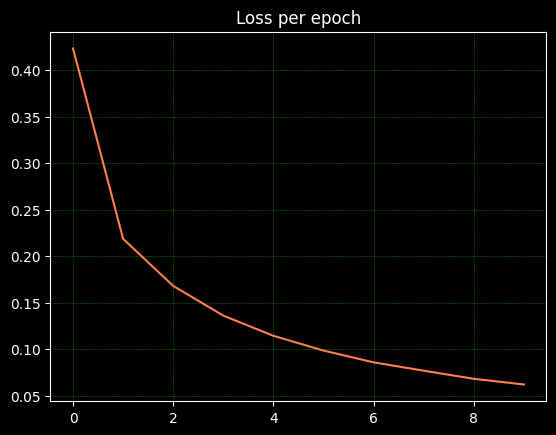

Validation:
-----------

Validation on training set:


100%|██████████| 938/938 [00:08<00:00, 105.54it/s]


Accuracy on training set: 98.50

Validation on testing set:


100%|██████████| 157/157 [00:02<00:00, 71.83it/s]


Accuracy on test set: 97.21

Example inference:
------------------


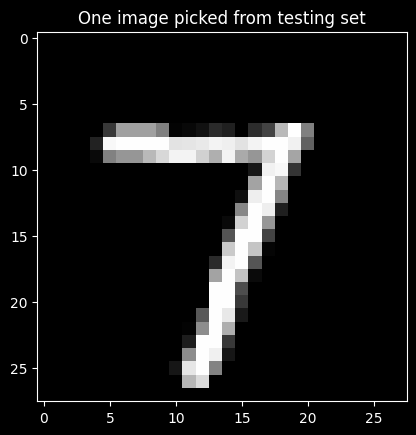

The predicted digit is 7


In [2]:
"""
A simple walkthrough of how to code a fully connected neural network
using the PyTorch library. For demonstration we train it on the very
common MNIST dataset of handwritten digits. In this code we go through
how to create the network as well as initialize a loss function, optimizer,
check accuracy and more.
Originally programmed by Aladdin Persson
Modified for learning by Chris Basoglu
"""

# Here we create our simple neural network. For more details here we are subclassing and
# inheriting from nn.Module, this is the most general way to create your networks and
# allows for more flexibility. I encourage you to also check out nn.Sequential which
# would be easier to use in this scenario but I wanted to show you something that
# "always" works and is a general approach.
#
# Input is 784, first hidden layer is 50 with activation function of relu, and then output layer is 10.
class NN(nn.Module):
    def __init__(self, input_size, num_classes):
        """
        Here we define the layers of the network. We create two fully connected layers
        Parameters:
            input_size: the size of the input, in this case 784 (28x28)
            num_classes: the number of classes we want to predict, in this case 10 (0-9)
        """
        # call the __init__() in the inherited base class.
        super(NN, self).__init__()

        # Our first linear layer take input_size, in this case 784 nodes to 50
        # and our second linear layer takes 50 to the num_classes we have, in
        # this case 10.

        # Input layer.  784 nodes in to 50 nodes out. 
        self.input_layer = nn.Linear(input_size, 50)

        # First and in this case only hidden layer.  Also serves as the output layer.  
        # 50 nodes in, 10 nodes (one per class) out.         
        self.hidden_layer_1 = nn.Linear(50, num_classes)

    def forward(self, x):
        """
        x here is the mnist images and we run it through input_layer, hidden_layer_1 that we created above.
        we also add a ReLU activation function in between and for that (since it has no parameters)
        I recommend using nn.functional (F)
        Parameters:
            x: mnist images
        Returns:
            out: the output of the network
        """

        x = F.relu(self.input_layer(x))
        x = self.hidden_layer_1(x)
        return x

# Check accuracy on training & test to see how good our model
def train_model(myloader, mymodel, mydevice, mylearning_rate, mynum_epochs):
    # Loss and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(mymodel.parameters(), lr=mylearning_rate)

    # Train Network

    # Put the model in training mode. If a neural network uses dropout or batch normalization, 
    # then you get different results when computing output values depending on whether the 
    # network is in train() or eval() mode.  We are training now, so switch to training mode.
    mymodel.train()  

    # Go over the dataset multiple times, each time is called an epoch.
    myloss_vals_per_epoch = []
    for epoch in range(mynum_epochs):
        loss_vals_within_epoch = []
        print(f"\nEpoch #{epoch}:")

        # loop over each batch within the dataset.
        for batch_idx, (data, targets) in enumerate(tqdm(myloader)):
            
            # so batch_idx will iterate from 0 to 937 (there are 938 total batches), for each batch,
            # data will have 64 images.  So data.shape would be [64, 1, 28, 28]  this means 64 images in the batch,
            # each image is 1 channel (black and white), and of dimension 28x28. 

            # Get data to cuda if possible
            data = data.to(device=mydevice)
            targets = targets.to(device=mydevice)

            # Get to correct shape within the batch.  We want to keep the fact that we have 64 images, so we keep the
            # first dimension fo the shape, data.shape[0], but we want to linearized into a vector everything else about
            # the image, so we can use -1 to tell pytorch to to that.  Alternatively, we could have explicitly set the shape 
            # to be 64 images, each image a single 784 element vector as data.reshape(data.shape[0], 784)
            data = data.reshape(data.shape[0], -1)

            # Forward pass. For each batch with 64 input images each reshaped into vector there are 10 outputs.  
            # Each of the 10 outputs (0-9) represents the likelihood that the corresponding digit is what was 
            # in the input image.  So scores has 64 rows of 10.  scores.shape would be: torch.Size([64, 10])  
            scores = mymodel(data)

            # compare results of the forward pass (cores) with the labels (targets) and compute the loss
            loss = criterion(scores, targets)
        
            # store each loss result for each batch.
            loss_vals_within_epoch.append(loss.item())

            # Backward pass with back prop (make sure to zero out the gradients first before computing them)
            optimizer.zero_grad()
            loss.backward()

            # Gradient descent or adam step.  All the model parameters get updated here.
            optimizer.step()

        # The loss for the epoch is the average loss across all the batches in that epoch.
        myloss_vals_per_epoch.append(sum(loss_vals_within_epoch)/len(loss_vals_within_epoch))
        print(f"current loss: {myloss_vals_per_epoch[len(myloss_vals_per_epoch)-1]}")
        
    return myloss_vals_per_epoch


# Check accuracy on training & test sets for validation to see how good our model
def check_accuracy(myloader, mymodel, mydevice):
    """
    Check accuracy of our trained model given a loader and a model
    Parameters:
        myloader: torch.utils.data.DataLoader
            A loader for the dataset you want to check accuracy on
        mymodel: nn.Module
            The model you want to check accuracy on
    Returns:
        acc: float
            The accuracy of the model on the dataset given by the loader
    """

    num_correct = 0
    num_samples = 0

    # Put the model in evaluation mode. If a neural network uses dropout or batch normalization, 
    # then you get different results when computing output values depending on whether the 
    # network is in train() or eval() mode.  We are evaluating now, so switch to eval mode.
    mymodel.eval()

    # We don't need to keep track of gradients here so we wrap it in torch.no_grad()
    with torch.no_grad():
        # Loop through the data
        for batch_idx, (data, targets) in enumerate(tqdm(myloader)):

            # Move data to device
            mydata = data.to(device=mydevice)
            mytargets = targets.to(device=mydevice)

            # Get to correct shape
            mydata_reshaped = mydata.reshape(mydata.shape[0], -1)

            # Forward pass. For each batch with 64 input images each reshaped into vector there are 10 outputs.  
            # Each of the 10 outputs (0-9) represents the likelihood that the corresponding digit is what was 
            # in the input image.  So scores has 64 rows of 10.  scores.shape would be: torch.Size([64, 10])  
            scores = mymodel(mydata_reshaped)

            # Instead of [64,10] if there where 3 total input images, each with 4 outputs, then scores might look like:
            #  a = torch.randn(3, 4)
            #    tensor([[-0.0361,  0.2515, -1.7277, -0.5487],
            #            [-0.9706,  1.8702, -0.9626,  0.1470],
            #            [ 0.1992, -1.2784, -2.2646, -0.0661]])
            # so the vertical dimension, per image direction is the first one (0). max(0) would give me the max 
            # of each column, not what I want.  To get the max of each class, the horizontal dimension, I want 
            # the second dimension (1) which is the max of each row. I also don't care about indices from where 
            # the maxes come, so I use _ to ignore the indices.           
            max_class_value_per_image, index_where_max_class_value_was_found_per_image = scores.max(1)
            
            # the index into the 10 class is the value of the predicted digit.
            predictions = index_where_max_class_value_was_found_per_image
            
            # Check how many we got correct
            num_correct += (predictions == mytargets).sum()

            # Keep track of number of samples. Count the number of samples in a batch (usually 64), 
            # this is the first dimension, and add for total.
            num_samples += predictions.size(0)

    # Reset model into training mode, which is the default state.
    mymodel.train()

    # Retrurn percentage correct.
    return num_correct / num_samples

# start main() here

# Set device cuda for GPU if it's available otherwise run on the CPU
devicestring = "cuda" if torch.cuda.is_available() else "cpu"
device = torch.device(devicestring)
print(f"Device used to run is: {devicestring}\n")

# Hyperparameters
input_size = 784
num_classes = 10
learning_rate = 0.001
the_batch_size = 64
num_epochs = 10

print("Data Loading:")
print("-------------\n")

# Lets use MNIST data which is a dataset of 60,000 training images.  Each image is of 28x28 pixels and is of a handwritten digit. 
# Each corresponding "target" is a integer that corresponds to what digit is drawn in the image. Load inputs and targets now.
train_dataset = datasets.MNIST(
    root="dataset/", train=True, transform=transforms.ToTensor(), download=True
)


# MNIST also has 10,000 testing images and targets. Load them now.
test_dataset = datasets.MNIST(
    root="dataset/", train=False, transform=transforms.ToTensor(), download=True
)

# split up the 60,000 image dataset, into batches of 64 images each.  
# There are 60,000 training images, and 60000/64=937.5, so we still get 938 total batches, 
# it is just that the last batch has only 32 images in it.  When using an iterator to 
# iterate over each bach, the shuffle=True part means before he data is split up into batches,
# the data is shuffled randomly.  That means there is a shuffle right as each epoch begins.
train_loader = DataLoader(dataset=train_dataset, batch_size=the_batch_size, shuffle=True)

# split up the 10,000 image dataset, into batches of 64 images each.  
# There are 10,000 testing images, and 10000/64=156.25, so we still get 157 total batches, 
# it is just that the last batch has only 16 images in it.  When using an iterator to 
# iterate over each bach, the shuffle=True part means before he data is split up into batches,
# the data is shuffled randomly. That means there is a shuffle right as each epoch begins.
test_loader = DataLoader(dataset=test_dataset, batch_size=the_batch_size, shuffle=True)

# visualize the first 3 images in the training set, but note there is shuffle first, so it will
# be a random first 3.
checkdata = iter(train_loader)
data, targets = next(checkdata)
fig, ax = plt.subplots(1, 3)
for i in range(3):
    ax[i].imshow(data[i][0], cmap="gray")
plt.suptitle("The first 3 input images after a shuffle", y=0.72)
plt.show()

# Show the first 3 targers (or lables as well)
print(f"The first 3 targets are: [{targets[0]}, {targets[1]}, {targets[2]}]\n")

# Initialize network.  The input is vector of 784 elements.  Each image is 28x28, and 28*28=784, 
# so each input is a vector that represents an image. As defined in NN class above, input is 784, 
# first hidden layer is 50 with activation function of relu, and then output layer is 10.
model = NN(input_size=input_size, num_classes=num_classes).to(device)

print("Training:")
print("---------")

# Train the model, iterate over batches, minimize the loss, parameters in the model get updated.
loss_vals_per_epoch = train_model(train_loader, model, device, learning_rate, num_epochs)

plt.plot(loss_vals_per_epoch, c = 'coral')
plt.title("Loss per epoch")
plt.grid(color = 'green', linestyle = '--', linewidth = 0.4)
plt.show()

print("Validation:")
print("-----------\n")

# Check accuracy on training set to see how good our model is
print("Validation on training set:")
accuracy_on_training_set = check_accuracy(train_loader, model, device)
print(f"Accuracy on training set: {accuracy_on_training_set*100:.2f}\n")

# Check accuracy on test set to see how good our model is
print("Validation on testing set:")
accuracy_on_test_set = check_accuracy(test_loader, model, device)
print(f"Accuracy on test set: {accuracy_on_test_set*100:.2f}\n")

print("Example inference:")
print("------------------")

# Pick one image from the test set
checkdata = iter(train_loader)
data, targets = next(checkdata)
mychosen_input = data[0]
plt.imshow(mychosen_input[0], cmap="gray")
plt.title("One image picked from testing set")
plt.show()

# Get to correct shape
mychosen_input = mychosen_input.to(device=device)
mychosen_input_reshaped = mychosen_input.reshape(mychosen_input.shape[0], -1)

# Forward pass.  See check_accuracy comments for details.
scores = model(mychosen_input_reshaped)
value, index = scores.max(1)
print(f"The predicted digit is {index.item()}")
            